In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from matplotlib import pyplot as plt 
import pandas as pd
from scipy.stats import zscore
from scipy import stats
from functools import reduce


##### load data

In [2]:
data = pd.read_csv('data/cas_intensities.csv', delimiter=',', index_col = 0)
# only use first repliate
data = data[data["replicate"]==1]
ms_data = data.drop(columns=["replicate"])
data_dist = ms_data.copy()
data_dist["sum"] = data_dist.apply(lambda row:row.sum(), axis=1)
data_dist['median']= data_dist.apply(lambda row:row[:-1].median(), axis=1)
data_dist['mean']= data_dist.apply(lambda row:row[:-2].mean(), axis=1)
data_norm = data_dist.apply(lambda row: row[:-3]/row['mean'],axis=1)
data_norm.index = data_dist.index
data_norm2 = data_norm.apply(lambda col:col/col.median(),axis=0)
ms_data = data_norm2

In [3]:
import numpy as np
df = ms_data
scaled_data = 3 * ((df - df.mean()) / df.std())

# Clip values to be within -3 and 3
scaled_data = np.clip(scaled_data, -3, 3)

# Check mean and standard deviation
print(scaled_data.mean())
print(scaled_data.std())
print(scaled_data.min(), scaled_data.max())


6485-40-1     -0.435880
3033-23-6      0.075711
21284-22-0    -0.418053
38427-78-0    -0.383695
495-61-4      -0.413705
                 ...   
713-95-1      -0.224200
20307-84-0    -0.413705
120021-96-7   -0.413705
586-62-9      -0.325871
710-04-3      -0.163435
Length: 732, dtype: float64
6485-40-1      1.894324
3033-23-6      2.302065
21284-22-0     1.891729
38427-78-0     2.084914
495-61-4       2.058207
                 ...   
713-95-1       2.258621
20307-84-0     2.058207
120021-96-7    2.058207
586-62-9       2.155720
710-04-3       1.986596
Length: 732, dtype: float64
6485-40-1     -3.0
3033-23-6     -3.0
21284-22-0    -3.0
38427-78-0    -3.0
495-61-4      -3.0
              ... 
713-95-1      -3.0
20307-84-0    -3.0
120021-96-7   -3.0
586-62-9      -3.0
710-04-3      -3.0
Length: 732, dtype: float64 6485-40-1      3.0
3033-23-6      3.0
21284-22-0     3.0
38427-78-0     3.0
495-61-4       3.0
              ... 
713-95-1       3.0
20307-84-0     3.0
120021-96-7    3.0
586-62-9

In [4]:
panelist_data_df = pd.read_table("data/vlb_data_combined.txt", delimiter=',', index_col = 1)
panelist_data_df = panelist_data_df[panelist_data_df["panelist"]==1]
panelist_data_df = panelist_data_df.drop(columns=["panelist", "date"])

In [5]:
# get only comparable samplekeys
valid_indexes = [index for index in panelist_data_df.index if index in ms_data.index]
ms_data_comp = scaled_data.loc[valid_indexes].fillna(0)
panelist_data_comp = panelist_data_df.loc[valid_indexes]

In [6]:
panelist_data_comp 

,Floral,Fruity,Woody,Complexity,Malt,Sweet,Peaty,Dried_fruits,Aftertaste
samplekey,,,,,,,,,
000656,50,20,60,50,30,30,50,40,40
000657,30,40,60,40,40,30,10,30,60
000658,30,50,50,50,40,40,10,40,70
000838,30,70,60,60,40,50,0,40,60
000839,50,60,60,60,40,50,0,30,70
...,...,...,...,...,...,...,...,...,...
000925,30,40,50,30,30,30,0,30,50
000926,50,40,50,60,40,40,50,40,60
000927,30,50,60,60,30,50,0,40,80


In [7]:
# find CAS number to each molecule
CAS_to_mol = pd.read_table("data/CAS_mol_OD.csv", delimiter=',',  names= ["CAS","intensity", "odor"])
CAS_to_mol=CAS_to_mol.drop(columns=["intensity","odor"])
CAS_to_mol= CAS_to_mol.drop_duplicates()

In [8]:
# all molecules that where labeled as sweet in flavornet
sweet_descriptors = ["benzyl alcohol","ethyl phenylacetate","tridecanal","nerol","methyl hexanoate","linalyl isovalerate","undecanaldehyde","caryophyllene oxide","linalyl acetate","safranal","uncineol","phenylethanal","p-anisaldehyde","eudesmol","ethylmethyl pyrazine","citronellyl butyrate","4-methyl-3-penten-2-one","nonyl acetate","10-epi-γ-eudesmol","β-bisabolol","(Z)-6-dodecene-γ-lactone","β-farnesene","2-dodecenal","γ-dodecalactone","epoxy-β-ionone","2-undecenal","styrene glycol","methyl furaneol","(-)-cis-rose oxide","(E)-β-ocimene","dimethylmethoxyfuranone","1,8-cineole","ethylbenzaldehyde","2-pentylthiophene","α-farnesene","methionol","7-methoxycoumarin","(Z)-3-hexenyl-2-methylbutanoate","o-aminoacetophenone","viridiflorol","isopiperitone","β-sinensal","ethyl vanillate","methyl butanoate","p-methoxystyrene","ethanol","6-Methoxyeugenol","4-hexanolide","δ-dodecalactone","sesquiphellandrene","diethyl malate","linalyl butyrate","guaiacol","coumarin","methyl benzoate","isopropyl benzoate","safrole","durene","γ-butyrolactone","ethyl isobutyrate","furfural"]
fruit_descriptors = ["ethyl phenylacetate", "geranyl valerate", "γ-heptalactone", "ethyl propionate", "diethyl acetal", "geranyl butyrate", "ethyl heptylate", "ethyl octanoate", "methyl hexanoate", "dimethylheptenal", "pentanone", "ethyl 3-methylbutanoate", "geranyl isovalerate", "isobutyl acetate", "ethoxypropanol", "methyl-2-butenal", "methylnonanedione", "linalyl acetate", "methyl geranate", "limonene oxide", "hydrocinnamic alcohol", "diethyl succinate", "ethyl hexanoate", "ethylmethyl pyrazine", "β-cubebene", "neryl acetate", "citronellyl butyrate", "hexyl acetate", "nonyl acetate", "butyl methylbutyrate", "pentenal", "isopentyldimethylpyrazine", "p-menth-1-en-9-ol", "hexadecanone", "octyl acetate", "γ-dodecalactone", "epoxy-β-ionone", "ethyl octenoate", "ethyl isohexanoate", "isobornyl propionate", "cedrenol", "p-menth-1-en-9-yl acetate", "cadinadiene", "(Z)-3-hexenyl hexanoate", "ethyl cyclohexanoate", "4-methylthio-2-butanone", "3,5-octadienone", "methyl cyclohexanecarboxylate", "2-pentylthiophene", "α-ocimene", "butanediol", "ethyl valerate", "pentanol", "isopiperitone", "butyl octanoate", "ethyl vanillate", "methyl butanoate", "2-methylbutyl acetate", "propyl hexanoate", "butyl hexanoate", "isopropyl butanoate", "spathulenol", "butanol", "δ-dodecalactone", "methyl quinoxaline", "sesquiphellandrene", "2-hexenol", "ethyl benzoate", "isopropyl benzoate", "ethyl lactate", "citronellyl isobutyrate"]
wood_descriptors = ["α-muurolene","cadina-1,4-dien-3-ol","isocaryophyllene","eudesmol","α-ionone","bornyl butyrate","(E)-α-bergamotene","linalool oxide","ethyl pyrazine","10-epi-γ-eudesmol","germacrene B","trans-sabinene hydrate","dihydrolinalool","isodihydrocarveol","β-farnesene","β-sesquiphellandrene","δ-elemene","α-calacorene","epoxy-β-ionone","germacrene D","bicyclogermacrene","alloaromadendrene","α-thujene","oxo-β-ionone","(-)-γ-elemene","γ-muurolene","sabinene","α-guaiene","α-copaene","γ-cadinene","nerolidol","β-eudesmol","α-cadinol","δ-cadinene","dill apiol","aromadendrene","α-gurjunene","guaiol","α-farnesene","γ-selinene","cuminica lcohol","perillen","elemol","α-humulene","β-caryophyllene","β-guaiene"]
malt_descriptors = ["pentanal","3-methyl-1-butanol","2-methyl-1-butanol","methylbutanal","isobutyraldehyde"]

In [9]:
# find cas numbers for these molecules
sweet_descriptors_CAS = [CAS_to_mol.loc[index]["CAS"]for index in sweet_descriptors if index in CAS_to_mol.index ]
fruit_descriptors_CAS = [CAS_to_mol.loc[index]["CAS"] for index in fruit_descriptors if index in CAS_to_mol.index]
wood_descriptors_CAS = [CAS_to_mol.loc[index]["CAS"] for index in wood_descriptors if index in CAS_to_mol.index]
malt_descriptors_CAS  =[CAS_to_mol.loc[index]["CAS"] for index in malt_descriptors if index in CAS_to_mol.index]

### Sweet

In [10]:
zscore_range=np.linspace(-3,3,25) # Since we only use zscored data, this range can be used everywhere 

cas_antecedents = [] # we can just use an array, since the names are saved in the antecedent objects
# we only use the sweet descriptors 
for cas in sweet_descriptors_CAS:
    cas_name = str(cas)  
    cas_antecedent = ctrl.Antecedent(zscore_range, cas_name)
    cas_antecedent.automf(3)
    
    cas_antecedents.append( cas_antecedent) 

osa_sweet = ctrl.Consequent(zscore_range, 'osa_sweet')
osa_sweet.automf(3)


In [17]:
# define some rules 
one_good =  reduce(lambda x, y: x | y, [ caa['good'] for caa in cas_antecedents])
one_avg =  reduce(lambda x, y: x | y, [ caa['average'] for caa in cas_antecedents])

all_poor =  reduce(lambda x, y: x & y, [ caa['poor'] for caa in cas_antecedents])
all_avg =  reduce(lambda x, y: x & y, [ caa['average'] for caa in cas_antecedents])

rules = [    
    ctrl.Rule( all_poor, osa_sweet['poor']   ),
    ctrl.Rule( all_avg, osa_sweet['average'] ),
    ctrl.Rule( one_good, osa_sweet['good']   )
]

In [12]:
# Set up the system 
fuzzy_ctrl = ctrl.ControlSystem(rules)
fuzzy = ctrl.ControlSystemSimulation(fuzzy_ctrl)

In [15]:
# Do some predictions

for cas_antecedent in  cas_antecedents:
    fuzzy.input[ cas_antecedent.label ] = -3
fuzzy.compute()
prediction = fuzzy.output['osa_sweet'] 

print( "For all poor, we get a prediction of :", prediction)


# all but one are under average 
fuzzy.input[cas_antecedents[0].label] = 0
fuzzy.compute()
prediction = fuzzy.output['osa_sweet'] 

print( "For only one good, we get a prediction of :", prediction )

ms_data = stats.zscore(ms_data_comp,axis=0)
predictions = []
for index, row in ms_data.iterrows():
    for cas in sweet_descriptors_CAS:
        fuzzy.input[ cas ] = row[cas]
    
    fuzzy.compute()  
    predictions.append(fuzzy.output['osa_sweet'])

references = np.array(panelist_data_comp['Sweet'])
       

For all poor, we get a prediction of : -2.0
For only one good, we get a prediction of : -3.0068540250264654e-17


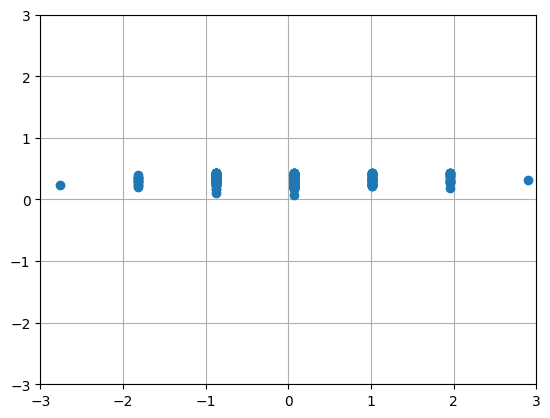

In [16]:
plt.plot(stats.zscore(references),predictions,"o")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()